In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
# Import the autocorrelation function (ACF) plot.
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from statsmodels.tsa.api import VAR

In [9]:
taxi_manhattan = pd.read_csv('./data/brooklyn_full.csv')

In [10]:
taxi_manhattan.head(2)

,Unnamed: 0,pickup_datetime,VendorID,dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,...,month,year,pickup_day_of_week,dropoff_day_of_week,pickup_hour,dropoff_hour,pickup_timeofday,pickup_borough,dropoff_borough,zone
0,70,2020-01-01 00:35:13,2.0,NaN,2.0,4.55,1.0,NaN,189,NaN,...,jan,2020,Wednesday,Wednesday,0,0,Late night,Brooklyn,Brooklyn,Prospect Heights
1,106,2020-01-01 00:12:28,2.0,NaN,1.0,1.50,1.0,NaN,40,NaN,...,jan,2020,Wednesday,Wednesday,0,0,Late night,Brooklyn,Brooklyn,Carroll Gardens


In [11]:
# taxi_manhattan['pickup_datetime'] = taxi_manhattan['Unnamed: 0']

In [12]:
taxi_manhattan['pickup_datetime'] = pd.to_datetime(taxi_manhattan['pickup_datetime'])


In [13]:
taxi_manhattan = taxi_manhattan.drop(columns='Unnamed: 0')

In [14]:
taxi_manhattan.head(2)

,pickup_datetime,VendorID,dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,month,year,pickup_day_of_week,dropoff_day_of_week,pickup_hour,dropoff_hour,pickup_timeofday,pickup_borough,dropoff_borough,zone
0,2020-01-01 00:35:13,2.0,NaN,2.0,4.55,1.0,NaN,189,NaN,1.0,...,jan,2020,Wednesday,Wednesday,0,0,Late night,Brooklyn,Brooklyn,Prospect Heights
1,2020-01-01 00:12:28,2.0,NaN,1.0,1.50,1.0,NaN,40,NaN,1.0,...,jan,2020,Wednesday,Wednesday,0,0,Late night,Brooklyn,Brooklyn,Carroll Gardens


In [15]:
taxi_manhattan.dtypes

pickup_datetime          datetime64[ns]
VendorID                        float64
dropoff_datetime                float64
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag              float64
PULocationID                      int64
DOLocationID                    float64
payment_type                    float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
month                            object
year                              int64
pickup_day_of_week               object
dropoff_day_of_week              object
pickup_hour                       int64
dropoff_hour                      int64
pickup_timeofday                 object


In [16]:
taxi_manhattan.set_index('pickup_datetime', inplace=True)

In [18]:
taxi_manhattan.reset_index()
taxi_manhattan.sort_index(inplace=True)

In [ ]:
taxi_manhattan.columns

In [23]:
# Code modified from code written by Matthew Garton.

def plot_series(df, cols=None, title='Title', xlab=None, ylab=None, steps=1):
    
    # Set figure size to be (18, 9).
    plt.figure(figsize=(18,9))
    legend_list = []
    
    # Iterate through each column name.
    for col in cols:
            
        # Generate a line plot of the column name.
        # You only have to specify Y, since our
        # index will be a datetime index.
        plt.plot(df[col])
        legend_list.append(col)
        
    # Generate title and labels.
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    
    # Enlarge tick marks.
    plt.yticks(fontsize=13)
    plt.xticks(df.index[0, 5, 10, 15, 20, 25, steps], fontsize=12)
    
    plt.legend(legend_list);

In [ ]:
df.index[0, 5, 10, 15, 20, 25, steps]

In [17]:
# taxi_manhattan.resample('H',closed='right')[['passenger_count',
#        'trip_distance', 'payment_type', 'fare_amount',
#        'tip_amount', 'tolls_amount', 'total_amount', 'congestion_surcharge']].sum()

In [20]:
# Our dataset is per ride and we converted it to a timeseries by day. 
# We will evaluate monthly, weekly, daily and 3hour window resampled timeseries. 
# Monthly has only 11*12 = 132 observations, weekly has 6864 and daily has 2505360. We wont need more data so will not spend much time on the 3hour modeling

# # Create new df for modeling which has the columns we need, by month
df_model = taxi_manhattan.resample("M").sum()[['passenger_count','trip_distance', 'fare_amount',
                                               'tip_amount', 'tolls_amount', 'congestion_surcharge']]

# # Create new df for modeling which has the columns we need, by week
df_model_week = taxi_manhattan.resample("W").sum()[['passenger_count','trip_distance', 'fare_amount',
                                                    'tip_amount', 'tolls_amount', 'congestion_surcharge']]

# Create new df for modeling which has the columns we need, by day 
df_model_day = taxi_manhattan.resample("D").sum()[['passenger_count','trip_distance', 'fare_amount','tip_amount', 'tolls_amount', 'congestion_surcharge']]

# Create new df for modeling which has the columns we need, by 3 hour window

df_model_3hour = taxi_manhattan.resample("3H").sum()[['passenger_count','trip_distance', 'fare_amount',
                                                      'tip_amount', 'tolls_amount', 'congestion_surcharge']]


IndexError: too many indices for array: array is 1-dimensional, but 7 were indexed

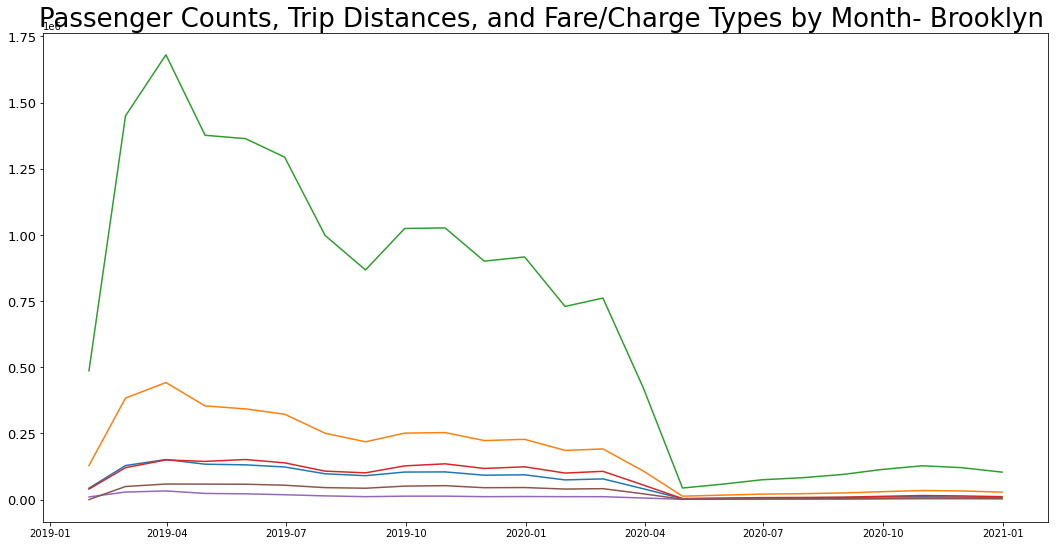

In [24]:
# 
plot_series(df_model, cols=['passenger_count','trip_distance', 'fare_amount',
                            'tip_amount', 'tolls_amount', 'congestion_surcharge'], 
            title="Passenger Counts, Trip Distances, and Fare/Charge Types by Month- Brooklyn ", steps = 12)

IndexError: too many indices for array: array is 1-dimensional, but 7 were indexed

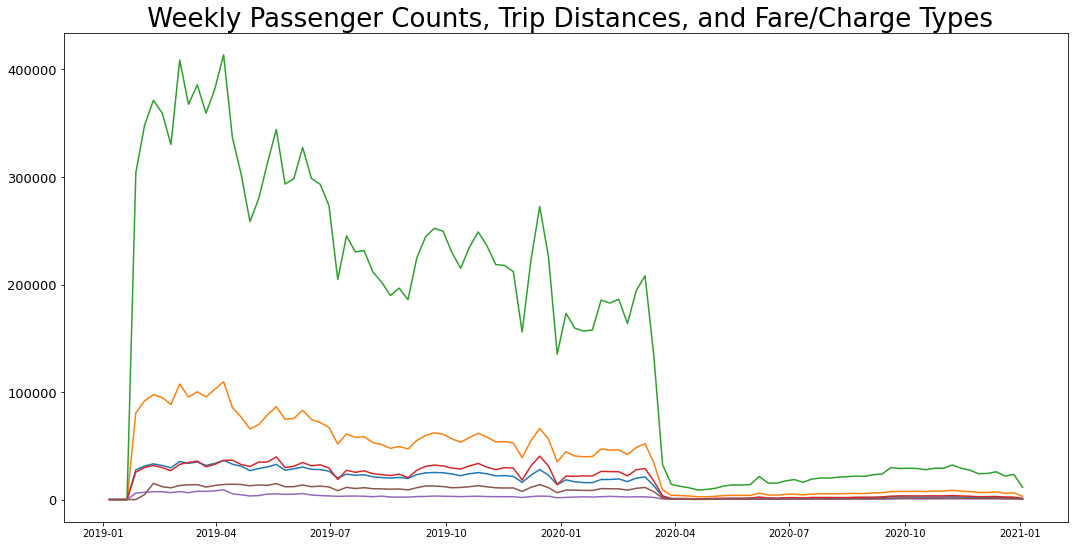

In [25]:
plot_series(df_model_week, cols=['passenger_count','trip_distance', 'fare_amount',
                            'tip_amount', 'tolls_amount', 'congestion_surcharge'], title=" Weekly Passenger Counts, Trip Distances, and Fare/Charge Types", steps = 52)


In [67]:
df_model_week.head()

,passenger_count,trip_distance,fare_amount,tip_amount,tolls_amount,congestion_surcharge
pickup_datetime,,,,,,
2019-01-06,10.0,13.70,70.00,13.70,0.00,0.00
2019-01-13,0.0,0.00,0.00,0.00,0.00,0.00
2019-01-20,615.0,824.30,3586.50,512.63,5.76,0.00
2019-01-27,2486744.0,3428835.62,16535363.07,2533502.69,215987.79,0.00
2019-02-03,2606921.0,3620649.44,17414977.59,2815831.86,226968.79,952152.25


In [26]:
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:3], index=['Test Statistic','p-value', 'Lag Used'])
    return dfoutput

### We're using Vector AutoRegressive Time series for modeling. 
We need to confirm stationarity of the data. 

Do the ADF (Augmented Dickey Fuller) statistical Test to confirm stationarity of the time series variables. If needed, do a diff one or more times until stationarity is achieved. 

In [27]:
interpret_dftest(adfuller(df_model['passenger_count']))

Test Statistic   -0.829119
p-value           0.810419
Lag Used          0.000000
dtype: float64

In [70]:
##Not stationary

In [28]:
interpret_dftest(adfuller(df_model['passenger_count'].diff().dropna())) # 

Test Statistic   -6.207694e+00
p-value           5.605459e-08
Lag Used          0.000000e+00
dtype: float64

In [73]:
# This is now stationary

In [29]:
# Create column.

df_model['first_diff_passenger_count'] = df_model['passenger_count'].diff()

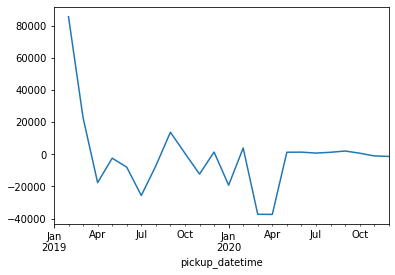

In [30]:
df_model['first_diff_passenger_count'].plot();

In [31]:
interpret_dftest(adfuller(df_model['trip_distance']))

Test Statistic   -0.945410
p-value           0.772651
Lag Used          0.000000
dtype: float64

In [32]:
interpret_dftest(adfuller(df_model['trip_distance'].diff().dropna()))

Test Statistic   -6.893492e+00
p-value           1.337037e-09
Lag Used          0.000000e+00
dtype: float64

In [33]:
df_model['first_diff_trip_distance'] = df_model['trip_distance'].diff()

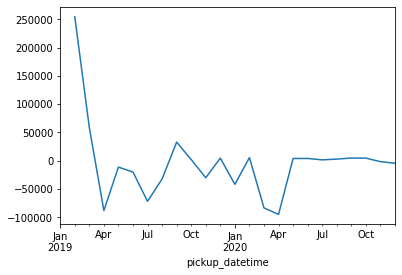

In [34]:
df_model['first_diff_trip_distance'].plot();

In [38]:
interpret_dftest(adfuller(df_model['fare_amount'].diff().dropna()))

Test Statistic   -6.639647e+00
p-value           5.450676e-09
Lag Used          0.000000e+00
dtype: float64

In [39]:
df_model['first_diff_fare_amount'] = df_model['fare_amount'].diff()

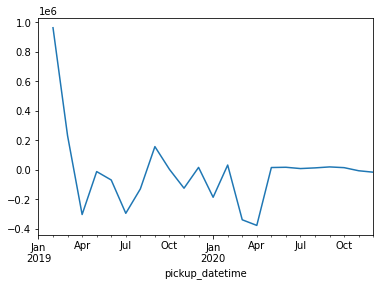

In [40]:
df_model['first_diff_fare_amount'].plot();

In [42]:
interpret_dftest(adfuller(df_model['congestion_surcharge'].diff().dropna()))

Test Statistic   -6.960172e+00
p-value           9.207938e-10
Lag Used          0.000000e+00
dtype: float64

In [43]:
df_model['first_diff_congestion_surcharge']= df_model['congestion_surcharge'].diff()

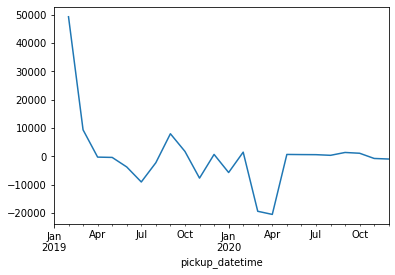

In [44]:
df_model['first_diff_congestion_surcharge'].plot();

In [46]:
interpret_dftest(adfuller(df_model['tip_amount'].diff().dropna()))

Test Statistic   -4.720973
p-value           0.000077
Lag Used          0.000000
dtype: float64

In [47]:
df_model['first_diff_tip_amount'] = df_model['tip_amount'].diff()

In [48]:
interpret_dftest(adfuller(df_model['tolls_amount'])) #stationary!

Test Statistic   -2.691986
p-value           0.075435
Lag Used          8.000000
dtype: float64

In [49]:
df_model.head(20)

,passenger_count,trip_distance,fare_amount,tip_amount,tolls_amount,congestion_surcharge,first_diff_passenger_count,first_diff_trip_distance,first_diff_fare_amount,first_diff_congestion_surcharge,first_diff_tip_amount
pickup_datetime,,,,,,,,,,,
2019-01-31,42911.0,128813.48,486598.68,39569.84,10022.99,0.00,NaN,NaN,NaN,NaN,NaN
2019-02-28,128493.0,383356.22,1449649.35,120574.39,28368.90,49322.25,85582.0,254542.74,963050.67,49322.25,81004.55
2019-03-31,151263.0,442071.97,1680355.77,149790.04,32596.98,58672.25,22770.0,58715.75,230706.42,9350.00,29215.65
2019-04-30,133612.0,353838.29,1376333.38,144144.83,23168.92,58375.00,-17651.0,-88233.68,-304022.39,-297.25,-5645.21
2019-05-31,131148.0,342527.40,1363555.99,151324.45,21668.34,57970.75,-2464.0,-11310.89,-12777.39,-404.25,7179.62
2019-06-30,123112.0,322433.90,1293653.53,138721.53,18242.08,54194.50,-8036.0,-20093.50,-69902.46,-3776.25,-12602.92
2019-07-31,97412.0,250530.60,997831.27,107419.62,13889.73,45109.00,-25700.0,-71903.30,-295822.26,-9085.50,-31301.91
2019-08-31,90189.0,218208.06,867473.83,100934.72,10935.39,42833.50,-7223.0,-32322.54,-130357.44,-2275.50,-6484.90
2019-09-30,103883.0,251035.50,1024107.39,127242.97,12839.81,50795.00,13694.0,32827.44,156633.56,7961.50,26308.25


Use the coefficient of correlation between two values in a time series, the autocorrelation function (ACF), to identify seasonality in our time series data. 

Use the ACF plot, a bar chart of the coefficients of correlation between a time series and lags of itself, to pick the points that are statistically significant (outside the blue shaded Confidence Interval region). 

Use the Partial autocorrelation (PACF), a statistical measure that captures the correlation between two variables after controlling for the effects of other variables, to confirm the statistically significant lags.


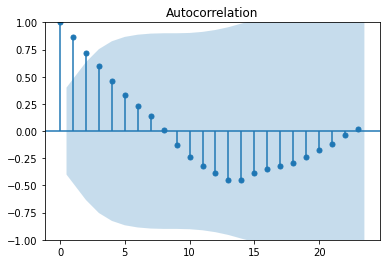

In [52]:
plot_acf(df_model['passenger_count'], lags=23);

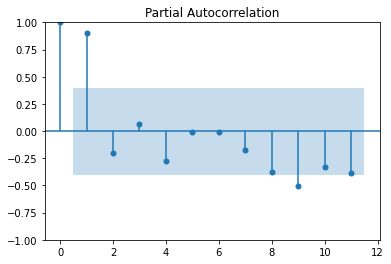

In [60]:
# Generate the PACF plot 

plot_pacf( df_model['passenger_count'], lags=11);

In [61]:
df_model.columns

Index(['passenger_count', 'trip_distance', 'fare_amount', 'tip_amount',
       'tolls_amount', 'congestion_surcharge', 'first_diff_passenger_count',
       'first_diff_trip_distance', 'first_diff_fare_amount',
       'first_diff_congestion_surcharge', 'first_diff_tip_amount'],
      dtype='object')

In [63]:
# Subset our data. Use our differenced columns
df_ts = df_model[['first_diff_passenger_count',
       'first_diff_trip_distance', 'first_diff_fare_amount',
       'first_diff_congestion_surcharge', 'first_diff_tip_amount']]

# Let's get rid of rows containing missing values.
df_ts.dropna(inplace = True)

df_ts



/Users/jonathanbeltran/opt/miniconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,first_diff_passenger_count,first_diff_trip_distance,first_diff_fare_amount,first_diff_congestion_surcharge,first_diff_tip_amount
pickup_datetime,,,,,
2019-02-28,85582.0,254542.74,963050.67,49322.25,81004.55
2019-03-31,22770.0,58715.75,230706.42,9350.00,29215.65
2019-04-30,-17651.0,-88233.68,-304022.39,-297.25,-5645.21
2019-05-31,-2464.0,-11310.89,-12777.39,-404.25,7179.62
2019-06-30,-8036.0,-20093.50,-69902.46,-3776.25,-12602.92
2019-07-31,-25700.0,-71903.30,-295822.26,-9085.50,-31301.91
2019-08-31,-7223.0,-32322.54,-130357.44,-2275.50,-6484.90
2019-09-30,13694.0,32827.44,156633.56,7961.50,26308.25
2019-10-31,597.0,2015.54,2253.89,1709.75,7791.13


In [64]:
train, test = train_test_split(df_ts, shuffle=False, 
                               test_size = 0.05) # use small test size, as we can't predict far into the future
# Out of 131 rows (dropped one null), train has 124 and test has 7

In [65]:
# Instantiate a VAR model. 

model = VAR(train, dates = train.index, freq='M')

In [66]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2 entries, 2020-11-30 to 2020-12-31
Freq: M
Data columns (total 5 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   first_diff_passenger_count       2 non-null      float64
 1   first_diff_trip_distance         2 non-null      float64
 2   first_diff_fare_amount           2 non-null      float64
 3   first_diff_congestion_surcharge  2 non-null      float64
 4   first_diff_tip_amount            2 non-null      float64
dtypes: float64(5)
memory usage: 96.0 bytes


In [67]:
# Fit our model and use AIC to select the value of p.

ts_model = model.fit(ic="aic")   # what "information criterion" (ic) will we use to decide what's "best?"

In [68]:

# What is the order of our autoregressive model? 
# Order ‘p’ means, up to p-lags of Y are used and they are the predictors in the equation
ts_model.k_ar

2

In [69]:
# Check out the summary of our model!
ts_model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 18, May, 2022
Time:                     17:00:49
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    88.1026
Nobs:                     19.0000    HQIC:                   85.8314
Log likelihood:          -890.802    FPE:                2.69769e+37
AIC:                      85.3687    Det(Omega_mle):     2.74886e+36
--------------------------------------------------------------------
Results for equation first_diff_passenger_count
                                        coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------------------
const                                  -2768.949291      6197.543451           -0.447           0.655
L1.first_diff_passenger_count              4.536144      

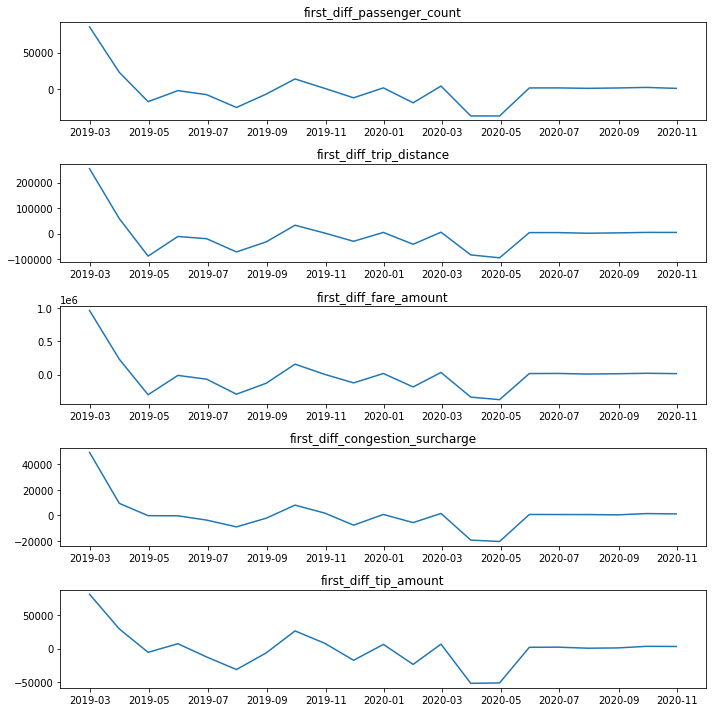

In [70]:
# Plot our training data.
ts_model.plot();
plt.tight_layout()

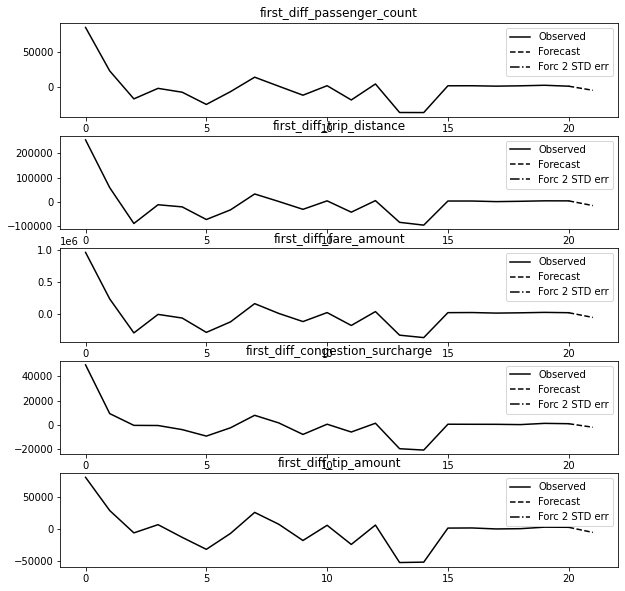

In [71]:
# Plot the forecast looking 3 steps ahead.
ts_model.plot_forecast(steps=1);


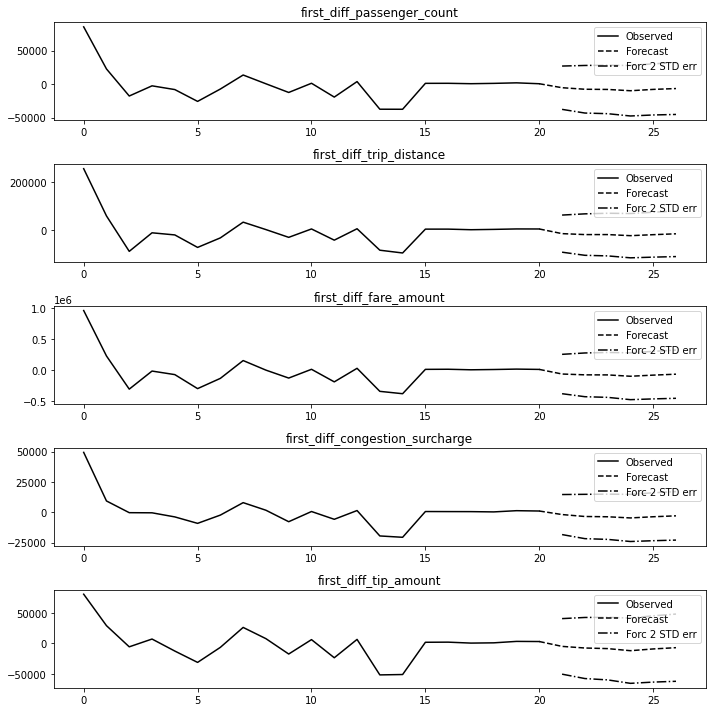

In [72]:
# Plot the forecast looking 10 steps ahead.
ts_model.plot_forecast(steps=6);
plt.tight_layout()


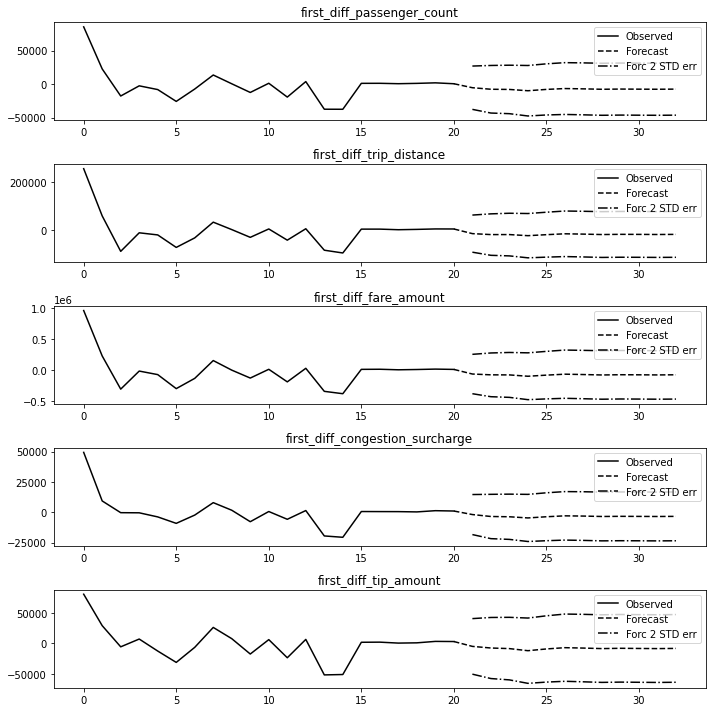

In [77]:
# Plot the forecast looking 11 steps ahead.
ts_model.plot_forecast(steps=12);
plt.tight_layout()


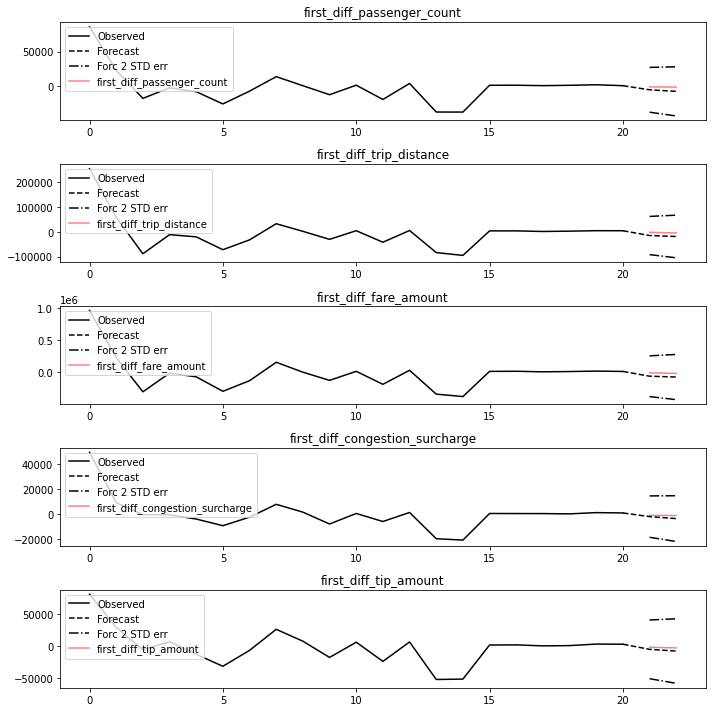

In [74]:
#Plot the forecast for the whole test set (and overlay the actual test values)
model_axes = ts_model.plot_forecast(test.shape[0]);
for i,ax in enumerate(model_axes.get_axes()):
     plot_df = test.iloc[:,i].reset_index(drop = True)
     plot_df.index += len(train)
     plot_df.plot(ax = ax, label = test.columns[i], color = 'red', alpha = 0.5)
     # zoom in 
     #plt.xlim(plot_df.index[-6], plot_df.index[-1])
     #plt.xlim(y_train.index[-15], y_test.index[-1])
     
     ax.legend(loc=2) # upper left
plt.tight_layout();

In [75]:
##Evaluating

In [76]:
# We'll use RMSE

# Save forecasted values
forecast = ts_model.forecast(train.values, len(test))

# Loop through columns and get RMSE for each
for i in range(test.shape[1]):
    print(f'The test RMSE on the {test.columns[i]} data is: {round(mean_squared_error(squared=False, y_true=test.values[:, i], y_pred=forecast[:, i]), 4)}')


The test RMSE on the first_diff_passenger_count data is: 5311.1744
The test RMSE on the first_diff_trip_distance data is: 13613.4285
The test RMSE on the first_diff_fare_amount data is: 55020.7551
The test RMSE on the first_diff_congestion_surcharge data is: 1895.0198
The test RMSE on the first_diff_tip_amount data is: 4200.6015


In [ ]:
## Start by making a dataframe of our model's forecasts
forecast_df = pd.DataFrame(data = ts_model.forecast(train.values, len(test)),
                           columns = test.columns, index = test.index)


In [ ]:

## Then we can undifference our once-differenced columns
### We do this by taking the last value from the original column before our test data
### and adding the cumulative summed first differenced forecasts
forecast_df['forecast_fatals'] = df_model['fatals'].iloc[-len(test)-1]  + forecast_df['first_diff_fatals'].cumsum()
forecast_df['forecast_drunk_dr'] = df_model['drunk_dr'].iloc[-len(test)-1]  + forecast_df['first_diff_drunk_dr'].cumsum()
forecast_df['forecast_peds'] = df_model['peds'].iloc[-len(test)-1]  + forecast_df['first_diff_peds'].cumsum()
